In [1]:
import os, sys
from tqdm import trange

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset

source = "../source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show
import data_analysis.visualization.publication as publication
from utils.containers import partition
import simulate

import models
from models import MLP


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

traj_path = "plots/XOR/"

GPU available


In [2]:
## Load settings
settings = "intermediate"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/XOR.txt", sep=" ", header=0).loc[settings].to_numpy()
)
model_type = getattr(models, model_type)
if nonlinearity == "discontinuous":
    nonlinearity = simulate.Discontinuous.apply
elif nonlinearity == "none":
    nonlinearity = None
else:
    nonlinearity = getattr(torch.nn.functional, nonlinearity)

mod = 1
# factor = 0.25
# n_epochs = int(factor * n_epochs)
# lr = lr / factor

# dy2 = 4
# dx2 = 9

In [3]:
## Load data
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs_XOR = np.array([[0], [1], [1], [0]])
outputs_OR = np.array([[0], [1], [1], [1]])

# outputs = np.array([[0], [1], [0], [1]])
outputs = outputs_XOR

outputs = torch.from_numpy(outputs.astype(np.float32)).to(device)
inputs = torch.from_numpy(inputs.astype(np.float32)).to(device)

input_labels = [(int(x[0].item()), int(x[1].item())) for x in inputs]

encoding = Direct()

dataset = TensorDataset(inputs, outputs)
train_datasets = [dataset]
val_dataset = [dataset]

tracked_datasets = val_dataset + train_datasets

In [4]:
# gain = 0.03
# P = 128
# L = 2

In [5]:
## Instantiate model
model = MLP(
    encoding=encoding,
    input_size=inputs.shape[1],
    output_size=outputs.shape[1],
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
    non_linearity=torch.nn.functional.relu,
)

In [6]:
input_1 = train_datasets[0][0][0]
input_2 = train_datasets[0][1][0]
hid_1 = model(input_1)[1][hidden_layer]
hid_2 = model(input_2)[1][hidden_layer]
pred_1 = model(input_1)[0]
pred_2 = model(input_2)[0]
input_1, input_2, hid_1, hid_2, pred_1, pred_2 = [
    a.detach().numpy() for a in (input_1, input_2, hid_1, hid_2, pred_1, pred_2)
]

G = np.linalg.norm(pred_2 - pred_1) ** 2 / np.linalg.norm(input_2 - input_1) ** 2
print(f"Overall gain: {G:.3e}, predicting {'rich' if (G < 1) else 'lazy'} learning!")

Overall gain: 9.071e-05, predicting rich learning!


/tmp/ipykernel_10811/3806243996.py:14: RuntimeWarning: invalid value encountered in divide
  (dist_h_0 / dist_x) ** 2 - (dist_y_0 / dist_h_0) ** 2 * eta_h / eta_y


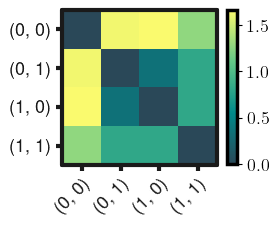

In [12]:
eta_h, eta_y = 1, 1

h_0 = [model(input)[1][hidden_layer].detach().numpy() for input in inputs]
y_0 = [model(input)[0].detach().numpy() for input in inputs]


dist_x = scipy.spatial.distance_matrix(inputs, inputs)
dist_y = scipy.spatial.distance_matrix(outputs, outputs)
dist_h_0 = scipy.spatial.distance_matrix(h_0, h_0)
dist_y_0 = scipy.spatial.distance_matrix(y_0, y_0)

A_low = np.sqrt(eta_h / eta_y) * dist_y * dist_x
A_high = (
    (dist_h_0 / dist_x) ** 2 - (dist_y_0 / dist_h_0) ** 2 * eta_h / eta_y
) * dist_x**2
h_final = np.sqrt(0.5 * (A_high + np.sqrt(A_high**2 + 4 * A_low**2)))
np.fill_diagonal(h_final, 0)

publication.set_color_gradient(index=2)
figsize = 2.5 * np.array([1, 1])
fig = plt.figure(figsize=figsize)

plt.imshow(h_final)
publication.im_show(
    x_labels=input_labels,
    y_labels=input_labels,
    save_path=traj_path + settings + "_theory",
)

In [8]:
## Setup compiler

# Define hyperparameters
# lr = 0.002 / P
# n_epochs = 10000

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model,
        lambda inputs: model(inputs)[1][hidden_layer],
        datasets=val_dataset,
    ),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=val_dataset
    ),
}

In [9]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=100
)

Training: 100%|██████████| 1000/1000 [00:37<00:00, 26.90steps/s, train_loss=0.00000, val_loss=0.00000]


/home/loek/projects/rnn/DNN/../source/utils/dataframes.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00.0' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  label.loc[index] = index
/home/loek/projects/rnn/DNN/../source/utils/dataframes.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  label.loc[index] = index


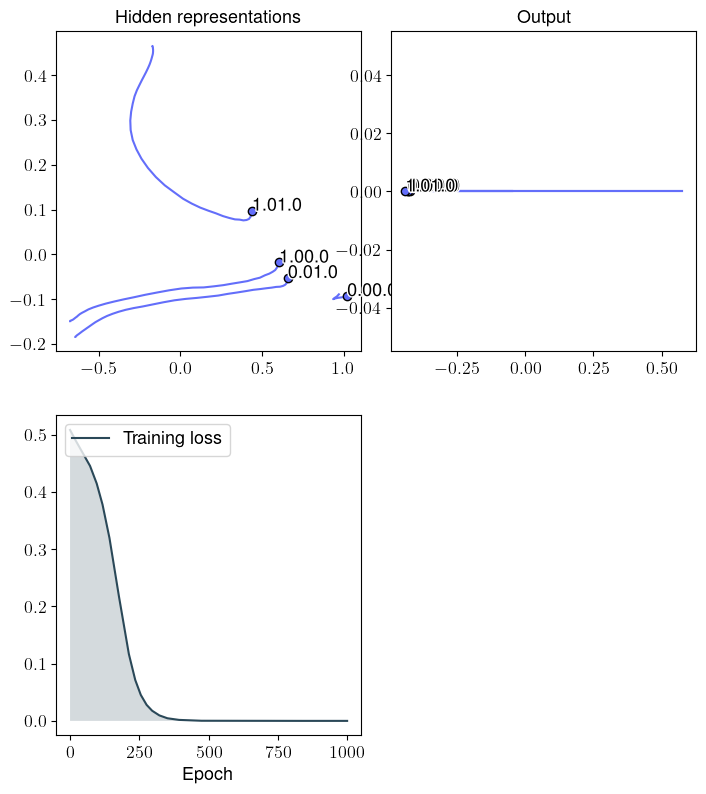

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 10…

In [10]:
## Visualize representation dynamics
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch % 10 == 0"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()

animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid, transform="PCA", plot_labels=True
        ),
        "Output": ActivationsAnimation(
            data_output,
            transform="PCA",
            plot_labels=True,
        ),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                # "Validation loss": val_loss,
            },
            unitless_graphs={},
            # x_bounds=(0, 800),
            # y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

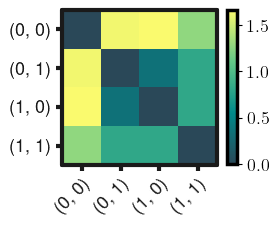

In [11]:
publication.set_color_gradient(index=2)
figsize = 2.5 * np.array([1, 1])

fig = plt.figure(figsize=figsize)

final_epoch = data_hid.index.get_level_values("Epoch")[-1]
h = data_hid.query(f"Epoch=={final_epoch}")
dist_h = scipy.spatial.distance_matrix(h, h)

plt.imshow(dist_h)

publication.im_show(
    x_labels=input_labels, y_labels=input_labels, save_path=traj_path + settings
)